In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [42]:
# if A = UDV' then
# A'A = UDV' VDU'= U(D^2)U'
# therefore eig(A'A) == svd(A'A)
# because:
# A'A U = U(D^2) = (D^2) U
# which is of the form
# AX = lambda X

class PCA:
    def __init__(self,n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.eigenvalues = None
        
    def fit(self, X):
        mu = X.mean(axis=0).reshape((1,-1))
        X_ = X - mu
        cov = np.matmul(X_.T, X_) # (d, d)
        # eigenvectors, eigenvalues = np.linalg.eig(cov) #eigenvectors is column-major
        U, D, Vt = np.linalg.svd(cov)
        eigenvectors = U
        eigenvalues = D
        print(eigenvectors.shape)
        # sort by highest eigvalues
        idx = np.argsort(eigenvalues)[::-1] # descending
        # print(idx)
        components = eigenvectors[:, idx].T
        self.components = components[:self.n_components, :] # n_comp x d
        self.mean = mu
        self.eigenvalues = eigenvalues[idx]
        
    def transform(self, X):
        X_ = X - self.mean # n x d
        # project X_ onto components
        coef = np.matmul(X_, self.components.T)
        return coef
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [43]:
from sklearn.datasets import fetch_lfw_people
# Load data
lfw_dataset = fetch_lfw_people(data_home='./data/',min_faces_per_person=25)
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
print(target_names)

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Bill Clinton' 'Colin Powell' 'David Beckham'
 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Gloria Macapagal Arroyo' 'Gray Davis' 'Guillermo Coria' 'Hans Blix'
 'Hugo Chavez' 'Jack Straw' 'Jacques Chirac' 'Jean Chretien'
 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva' 'Mahmoud Abbas'
 'Megawati Sukarnoputri' 'Nestor Kirchner' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Daschle' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']


In [44]:
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape) # N x (2914 pixels)
print(X_test.shape)

(2070, 2914)
(518, 2914)


In [46]:
pca = PCA(n_components=20)

In [47]:
pca.fit(X_train)
print(pca.eigenvalues)

(2914, 2914)
[1.9596383e+09 1.1834348e+09 6.7115635e+08 ... 1.0430989e-02 5.2298382e-03
 9.8662917e-05]


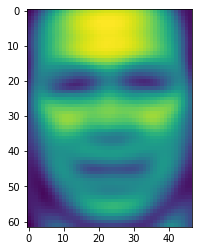

In [48]:
plt.imshow(pca.mean.reshape((h,w)))
plt.show()

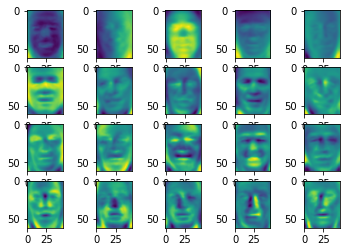

In [49]:
for i, comp in enumerate(pca.components):
    plt.subplot(4,5,i+1)
    plt.imshow(comp.reshape((h,w)))
plt.show()

In [56]:
c = pca.transform(X_test[0])
print(c)

[[2170.369    -879.99634  -612.63824   858.1576    357.34625  -198.4121
   350.26703   379.23145   332.94083  -158.52734   -33.731873   11.366068
   167.95444   -39.814644 -448.35345    11.734174   39.15607  -228.17133
   -43.888702 -215.01996 ]]


In [54]:
# reduce input dimensionality
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)